# Common Test I. Multi-Class Classification

In [1]:
!gdown 1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ

Downloading...
From (original): https://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ
From (redirected): https://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ&confirm=t&uuid=e6c5ced4-0770-4057-9c8d-95de0d832658
To: /content/dataset.zip
100% 1.13G/1.13G [00:16<00:00, 67.1MB/s]


In [2]:
!unzip /content/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/val/no/531.npy  
  inflating: dataset/val/no/257.npy  
  inflating: dataset/val/no/243.npy  
  inflating: dataset/val/no/525.npy  
  inflating: dataset/val/no/1099.npy  
  inflating: dataset/val/no/1927.npy  
  inflating: dataset/val/no/1933.npy  
  inflating: dataset/val/no/519.npy  
  inflating: dataset/val/no/1066.npy  
  inflating: dataset/val/no/1700.npy  
  inflating: dataset/val/no/294.npy  
  inflating: dataset/val/no/2209.npy  
  inflating: dataset/val/no/280.npy  
  inflating: dataset/val/no/1714.npy  
  inflating: dataset/val/no/1072.npy  
  inflating: dataset/val/no/2235.npy  
  inflating: dataset/val/no/1728.npy  
  inflating: dataset/val/no/2221.npy  
  inflating: dataset/val/no/733.npy  
  inflating: dataset/val/no/727.npy  
  inflating: dataset/val/no/1502.npy  
  inflating: dataset/val/no/1264.npy  
  inflating: dataset/val/no/928.npy  
  inflating: dataset/val/no/1270.npy  
  inflating: dataset/va

In [3]:
import os
import glob
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
import math
from timm import create_model
from tqdm import tqdm

In [4]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"Memory cached: {torch.cuda.memory_cached(0) / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA L4
Memory allocated: 1.47 GB
Memory cached: 2.28 GB


<ipython-input-15-bf90bd893c2b>:5: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print(f"Memory cached: {torch.cuda.memory_cached(0) / 1e9:.2f} GB")


In [14]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()

In [16]:
class NPYDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img = np.load(self.file_list[idx])
        img = np.squeeze(img)

        if img.ndim == 2:
            img = np.stack([img, img, img], axis=-1)
        elif img.ndim == 3:
            if img.shape[0] == 1:
                img = np.repeat(img, 3, axis=0)
                img = np.transpose(img, (1, 2, 0))
            elif img.shape[0] == 3:
                img = np.transpose(img, (1, 2, 0))
        else:
            raise ValueError("Unexpected image shape: {}".format(img.shape))

        img = Image.fromarray((img * 255).astype(np.uint8))

        if self.transform is not None:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

In [17]:
class SelfAttention2d(nn.Module):
    def __init__(self, in_channels, dropout=0.1):
        super(SelfAttention2d, self).__init__()
        self.in_channels = in_channels

        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv   = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
        self.dropout_attn = nn.Dropout(dropout)
        nn.init.xavier_uniform_(self.query_conv.weight)
        nn.init.xavier_uniform_(self.key_conv.weight)
        nn.init.xavier_uniform_(self.value_conv.weight)

    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = self.query_conv(x).view(B, -1, H * W).permute(0, 2, 1)
        proj_key   = self.key_conv(x).view(B, -1, H * W)
        energy = torch.bmm(proj_query, proj_key)

        attention = self.softmax(energy)
        attention = self.dropout_attn(attention)
        proj_value = self.value_conv(x).view(B, -1, H * W)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        out = self.gamma * out + x
        return out

class ModelNet(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.5):
        super(ModelNet, self).__init__()
        backbone = torchvision.models.resnet50(pretrained=True)
        backbone.fc = nn.Identity()
        self.backbone = backbone
        self.attention = SelfAttention2d(in_channels=2048)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        x = self.attention(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [18]:
def load_dataset_paths(root_dir):
    classes = {'no': 0, 'sphere': 1, 'vort': 2}
    file_paths = []
    labels = []
    for cls_name, label in classes.items():
        folder = os.path.join(root_dir, cls_name)
        files = glob.glob(os.path.join(folder, "*.npy"))
        file_paths.extend(files)
        labels.extend([label] * len(files))
    return file_paths, labels

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        all_preds.append(outputs.detach().cpu())
        all_labels.append(labels.detach().cpu())
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    _, preds = torch.max(all_preds, 1)
    acc = accuracy_score(all_labels, preds)
    return epoch_loss, acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            all_preds.append(outputs.detach().cpu())
            all_labels.append(labels.detach().cpu())
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    _, preds = torch.max(all_preds, 1)
    acc = accuracy_score(all_labels, preds)
    probs = torch.softmax(all_preds, dim=1).numpy()
    labels_onehot = np.eye(3)[all_labels.numpy()]
    try:
        auc = roc_auc_score(labels_onehot, probs, multi_class='ovr')
    except ValueError:
        auc = 0.0
    return epoch_loss, acc, auc

In [19]:
def run_training(root_dir, n_splits=3, num_epochs=15, batch_size=10, lr=1e-4):
    file_paths, labels = load_dataset_paths(root_dir)
    labels = np.array(labels)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    fold_results = {}

    for fold, (train_idx, val_idx) in enumerate(skf.split(file_paths, labels)):
        print(f"\n--- Fold {fold+1} ---")

        train_files = [file_paths[i] for i in train_idx]
        train_labels = labels[train_idx]
        val_files = [file_paths[i] for i in val_idx]
        val_labels = labels[val_idx]

        train_dataset = NPYDataset(train_files, train_labels, transform=train_transform)
        val_dataset   = NPYDataset(val_files, val_labels, transform=val_transform)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        model = ModelNet(num_classes=3)
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        best_val_auc = 0.0

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

            val_loss, val_acc, val_auc = evaluate(model, val_loader, criterion, device)
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val ROC AUC: {val_auc:.4f}")

            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_model_wts = model.state_dict()

        model_save_path = f"efficientnet_fold{fold+1}.pth"
        torch.save(best_model_wts, model_save_path)
        print(f"Best model for Fold {fold+1} saved at {model_save_path}")

        fold_results[f"Fold {fold+1}"] = {"val_loss": val_loss, "val_acc": val_acc, "val_auc": val_auc}

    print("\n--- Cross Validation Results ---")
    for fold, metrics in fold_results.items():
        print(f"{fold}: Loss: {metrics['val_loss']:.4f}, Acc: {metrics['val_acc']:.4f}, ROC AUC: {metrics['val_auc']:.4f}")

train_root = "/content/dataset/train"
run_training(train_root, n_splits=3, num_epochs=10, batch_size=32, lr=1e-4)

Using device: cuda

--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 88.8MB/s]



Epoch 1/10


Train Loss: 0.8638, Train Acc: 0.5684


Val Loss: 0.4974, Val Acc: 0.8011, Val ROC AUC: 0.9376

Epoch 2/10


Train Loss: 0.4512, Train Acc: 0.8273


Val Loss: 0.3318, Val Acc: 0.8710, Val ROC AUC: 0.9690

Epoch 3/10


Train Loss: 0.3468, Train Acc: 0.8702


Val Loss: 0.3843, Val Acc: 0.8697, Val ROC AUC: 0.9715

Epoch 4/10


Train Loss: 0.2982, Train Acc: 0.8907


Val Loss: 0.2429, Val Acc: 0.9092, Val ROC AUC: 0.9837

Epoch 5/10


Train Loss: 0.2734, Train Acc: 0.9006


Val Loss: 0.2599, Val Acc: 0.9077, Val ROC AUC: 0.9813

Epoch 6/10


Train Loss: 0.2430, Train Acc: 0.9113


Val Loss: 0.2909, Val Acc: 0.9012, Val ROC AUC: 0.9819

Epoch 7/10


Train Loss: 0.2266, Train Acc: 0.9195


Val Loss: 0.2017, Val Acc: 0.9278, Val ROC AUC: 0.9873

Epoch 8/10


Train Loss: 0.2112, Train Acc: 0.9245


Val Loss: 0.2190, Val Acc: 0.9246, Val ROC AUC: 0.9868

Epoch 9/10


Train Loss: 0.1981, Train Acc: 0.9304


Val Loss: 0.1955, Val Acc: 0.9287, Val ROC AUC: 0.9881

Epoch 10/10


Train Loss: 0.1859, Train Acc: 0.9335


Val Loss: 0.1719, Val Acc: 0.9422, Val ROC AUC: 0.9899
Best model for Fold 1 saved at efficientnet_fold1.pth

--- Fold 2 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10


Train Loss: 0.8737, Train Acc: 0.5619


Val Loss: 0.5819, Val Acc: 0.7637, Val ROC AUC: 0.9256

Epoch 2/10


Train Loss: 0.4612, Train Acc: 0.8177


Val Loss: 0.3735, Val Acc: 0.8684, Val ROC AUC: 0.9663

Epoch 3/10


Train Loss: 0.3588, Train Acc: 0.8661


Val Loss: 0.3192, Val Acc: 0.8877, Val ROC AUC: 0.9747

Epoch 4/10


Train Loss: 0.3024, Train Acc: 0.8899


Val Loss: 0.2507, Val Acc: 0.9132, Val ROC AUC: 0.9818

Epoch 5/10


Train Loss: 0.2770, Train Acc: 0.8977


Val Loss: 0.2890, Val Acc: 0.8962, Val ROC AUC: 0.9810

Epoch 6/10


Train Loss: 0.2517, Train Acc: 0.9102


Val Loss: 0.2163, Val Acc: 0.9238, Val ROC AUC: 0.9863

Epoch 7/10


Train Loss: 0.2346, Train Acc: 0.9171


Val Loss: 0.2049, Val Acc: 0.9274, Val ROC AUC: 0.9872

Epoch 8/10


Train Loss: 0.2117, Train Acc: 0.9239


Val Loss: 0.2104, Val Acc: 0.9286, Val ROC AUC: 0.9860

Epoch 9/10


Train Loss: 0.2035, Train Acc: 0.9270


Val Loss: 0.2208, Val Acc: 0.9225, Val ROC AUC: 0.9870

Epoch 10/10


Train Loss: 0.1946, Train Acc: 0.9302


Val Loss: 0.2049, Val Acc: 0.9261, Val ROC AUC: 0.9881
Best model for Fold 2 saved at efficientnet_fold2.pth

--- Fold 3 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10


Train Loss: 0.8714, Train Acc: 0.5566


Val Loss: 0.5527, Val Acc: 0.7757, Val ROC AUC: 0.9259

Epoch 2/10


Train Loss: 0.4493, Train Acc: 0.8273


Val Loss: 0.3901, Val Acc: 0.8562, Val ROC AUC: 0.9630

Epoch 3/10


Train Loss: 0.3530, Train Acc: 0.8680


Val Loss: 0.2925, Val Acc: 0.8922, Val ROC AUC: 0.9763

Epoch 4/10


Train Loss: 0.3007, Train Acc: 0.8888


Val Loss: 0.2416, Val Acc: 0.9110, Val ROC AUC: 0.9827

Epoch 5/10


Train Loss: 0.2725, Train Acc: 0.8994


Val Loss: 0.2588, Val Acc: 0.9041, Val ROC AUC: 0.9800

Epoch 6/10


Train Loss: 0.2515, Train Acc: 0.9069


Val Loss: 0.2197, Val Acc: 0.9232, Val ROC AUC: 0.9856

Epoch 7/10


Train Loss: 0.2241, Train Acc: 0.9192


Val Loss: 0.2343, Val Acc: 0.9231, Val ROC AUC: 0.9859

Epoch 8/10


Train Loss: 0.2173, Train Acc: 0.9211


Val Loss: 0.1929, Val Acc: 0.9315, Val ROC AUC: 0.9889

Epoch 9/10


Train Loss: 0.2006, Train Acc: 0.9285


Val Loss: 0.2054, Val Acc: 0.9303, Val ROC AUC: 0.9866

Epoch 10/10


Train Loss: 0.1982, Train Acc: 0.9297


Val Loss: 0.1947, Val Acc: 0.9366, Val ROC AUC: 0.9887
Best model for Fold 3 saved at efficientnet_fold3.pth

--- Cross Validation Results ---
Fold 1: Loss: 0.1719, Acc: 0.9422, ROC AUC: 0.9899
Fold 2: Loss: 0.2049, Acc: 0.9261, ROC AUC: 0.9881
Fold 3: Loss: 0.1947, Acc: 0.9366, ROC AUC: 0.9887


In [20]:
import cv2
import matplotlib.pyplot as plt

In [21]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        self.model.eval()
        input_tensor.requires_grad = True

        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax().item()

        self.model.zero_grad()
        output[:, class_idx].backward(retain_graph=True)

        gradients = self.gradients.detach()
        activations = self.activations.detach()
        pooled_grads = torch.mean(gradients, dim=[0, 2, 3])

        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_grads[i]

        heatmap = torch.mean(activations, dim=1).squeeze().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap = heatmap / np.max(heatmap)

        return heatmap

In [ ]:
model = ModelNet(num_classes=3).to(device)
model.load_state_dict(torch.load("/content/fold_best_FMGL_Submit.pth"))
model.eval()

target_layer = model.backbone.layer4[-1]

gradcam = GradCAM(model, target_layer)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-61-3fe5b45d2dc1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

In [62]:
def preprocess_image(npy_file):
    image = np.load(npy_file)
    image = torch.tensor(image).unsqueeze(0)
    image = image.expand(1, 3, *image.shape[2:])
    image = image.float().to(device)
    return image

def overlay_heatmap(image_path, heatmap):
    original_img = np.load(image_path)[0]
    original_img = cv2.resize(original_img, (224, 224))

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * 0.5 + np.expand_dims(original_img, axis=-1)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    return superimposed_img

In [63]:
def visualize_gradcam(model, gradcam, image_path):
    input_tensor = preprocess_image(image_path)
    heatmap = gradcam.generate_cam(input_tensor)
    result_image = overlay_heatmap(image_path, heatmap)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(np.load(image_path)[0], cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(result_image)
    plt.title("Grad-CAM Heatmap")

    plt.show()

In [64]:
def visualize_activations(model, image_path):
    model.eval()
    image = preprocess_image(image_path)

    layers = [model.backbone.layer1, model.backbone.layer2, model.backbone.layer3]
    activations = []

    x = model.backbone.conv1(image)
    x = model.backbone.bn1(x)
    x = model.backbone.relu(x)
    x = model.backbone.maxpool(x)

    for layer in layers:
        x = layer(x)
        activations.append(x.detach().cpu())

    fig, axes = plt.subplots(1, len(activations), figsize=(15, 5))
    for i, activation in enumerate(activations):
        ax = axes[i]
        act_map = activation[0, 0].numpy()
        ax.imshow(act_map, cmap='viridis')
        ax.set_title(f"Layer {i+1} Activation")
    plt.show()

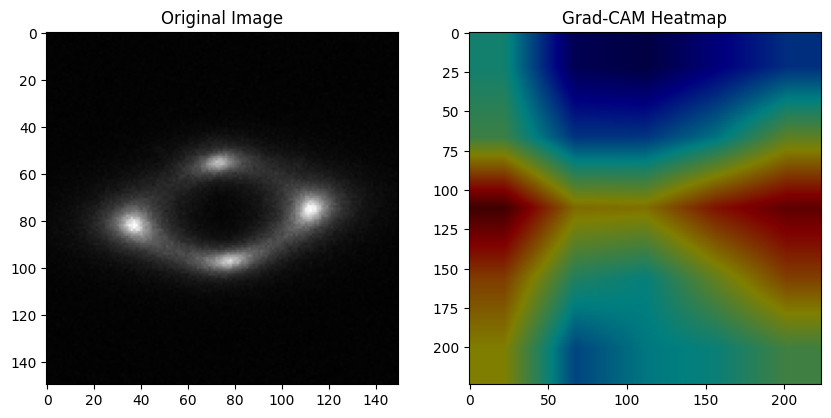

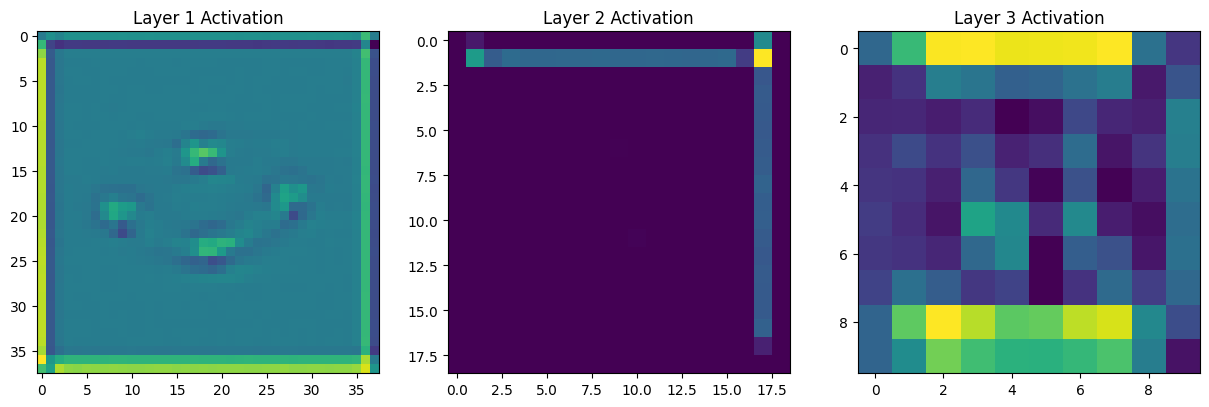

In [95]:
test_image_path = "/content/dataset/train/sphere/1111.npy"
visualize_gradcam(model, gradcam, test_image_path)
visualize_activations(model, test_image_path)

In [103]:
class_labels = ["no", "sphere", "vort"]

def load_npy_image(npy_file):
    arr = np.load(npy_file)
    arr = np.squeeze(arr)

    if arr.ndim == 2:
        arr = np.stack([arr, arr, arr], axis=-1)
    elif arr.ndim == 3:
        if arr.shape[0] == 1:
            arr = np.repeat(arr, 3, axis=0)
            arr = np.transpose(arr, (1, 2, 0))
        elif arr.shape[0] == 3:
            arr = np.transpose(arr, (1, 2, 0))
    else:
        raise ValueError("Unexpected image shape: {}".format(arr.shape))

    img = Image.fromarray((arr * 255).astype(np.uint8))
    return img

def predict_npy(npy_file, model, device):
    image = load_npy_image(npy_file)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_idx = probabilities.argmax(dim=1).item()

    predicted_label = class_labels[predicted_idx]
    return predicted_label, probabilities.cpu().numpy()

In [104]:
categories = ["vort", "sphere", "no"]

for category in categories:
    count = 0
    folder = f"/content/dataset/val/{category}/"

    for i in range(2500):
        npy_file = f"{folder}{i+1}.npy"
        label, probs = predict_npy(npy_file, model, device)

        if label == category:
            count += 1

    print(f"'{category}': {(count/2500)*100}%")

'vort': 93.64%
'sphere': 89.52%
'no': 96.0%


In [105]:
valAuc = [["vort", 93.64], ["sphere", 89.52], ["no", 96.0]]

Here, we have to check for the cause of `sphere` class having lower validation prediction accuray than the `no` and `vort`.